# Diagnostic Analytics — Root Cause of Late Deliveries (Solutions)

This notebook is a self-contained addendum with five scenarios:
1. Customs Impact (+2 days for Sea)
2. Linehaul Disruption (+1 day for Road)
3. SLA Relaxation (Sea SLA 18 → 20)
4. Process Improvement (Pick & Depart −20%)
5. Late Definition Change (Late if LeadTime > SLA + 1)

It also builds a baseline synthetic dataset compatible with the class demo.

## Setup and Synthetic Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

rng = np.random.default_rng(7)

# --- Create staged event dataset ---
N = 500
mode = rng.choice(["Road","Air","Sea"], p=[0.6,0.2,0.2], size=N)
order_day = pd.to_datetime("2025-01-01") + pd.to_timedelta(rng.integers(0,60,size=N), unit="D")

# Stage durations (in days) with mode effects
pick = rng.normal(0.5, 0.2, size=N).clip(0.1,2.0)
depart = rng.normal(0.2, 0.1, size=N).clip(0.05,1.0)
customs = np.where(mode=="Sea", rng.normal(3.0,1.2,size=N), rng.normal(0.6,0.4,size=N)).clip(0,8)
linehaul = np.where(mode=="Air", rng.normal(1.8,0.5,size=N),
            np.where(mode=="Road", rng.normal(3.0,1.0,size=N), rng.normal(10,3,size=N))).clip(0.5,20)
lastmile = rng.normal(0.7,0.3,size=N).clip(0.2,3.0)

lead = pick+depart+customs+linehaul+lastmile
sla = np.where(mode=="Air", 4, np.where(mode=="Road", 7, 18))
late = lead > sla

stages = pd.DataFrame({
    "Mode": mode, "OrderDate": order_day,
    "Pick": pick.round(2), "Depart": depart.round(2),
    "Customs": customs.round(2), "Linehaul": linehaul.round(2),
    "LastMile": lastmile.round(2), "LeadTime": lead.round(2),
    "SLA": sla, "Late": late
})

# Benchmarks (expected duration in days) for RootCause logic
bench = {"Pick":0.6, "Depart":0.3, "Customs":1.0, "Linehaul":2.5, "LastMile":0.8}

def root_cause(row):
    overs = {s: row[s]-bench[s] for s in bench if row[s] > bench[s]}
    return max(overs, key=overs.get) if overs else "None"

stages["RootCause"] = stages.apply(root_cause, axis=1)

# Baseline Pareto for orientation
pareto = (stages[stages["Late"]]["RootCause"]
          .value_counts()
          .rename_axis("Cause")
          .reset_index(name="LateCount"))

pareto.head()

,Cause,LateCount
0,Linehaul,26
1,LastMile,17
2,Pick,7
3,Customs,6
4,None,5


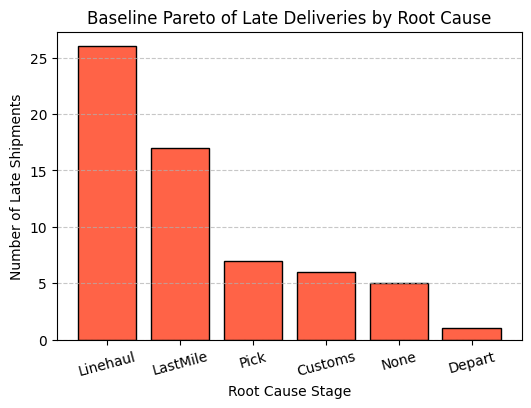

In [2]:
plt.figure(figsize=(6,4))
plt.bar(pareto["Cause"], pareto["LateCount"], color="tomato", edgecolor="black")
plt.title("Baseline Pareto of Late Deliveries by Root Cause")
plt.ylabel("Number of Late Shipments")
plt.xlabel("Root Cause Stage")
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Helper: Recompute and Plot Utilities

In [3]:
# Keep a pristine baseline
stages0 = stages.copy()

def recompute_metrics(df, late_offset_days=0):
    """Recompute LeadTime, RootCause, Late flag, Pareto table, and OTIF."""
    df = df.copy()
    df["LeadTime"] = (df["Pick"] + df["Depart"] + df["Customs"] + df["Linehaul"] + df["LastMile"]).round(2)
    df["RootCause"] = df.apply(root_cause, axis=1)
    df["Late"] = df["LeadTime"] > (df["SLA"] + late_offset_days)

    pareto = (df[df["Late"]]["RootCause"]
              .value_counts()
              .rename_axis("Cause")
              .reset_index(name="LateCount"))
    otif_pct = (1 - df["Late"].mean()) * 100
    return df, pareto, otif_pct

def plot_pareto(pareto, title="Pareto of Late Deliveries by Root Cause"):
    plt.figure(figsize=(6,4))
    plt.bar(pareto["Cause"], pareto["LateCount"], edgecolor="black")
    plt.title(title)
    plt.ylabel("Late Shipments"); plt.xlabel("Root Cause")
    plt.xticks(rotation=15); plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.show()

## Scenario 1 — Customs Impact (Sea +2 days)

OTIF after +2d customs for Sea: 84.8%


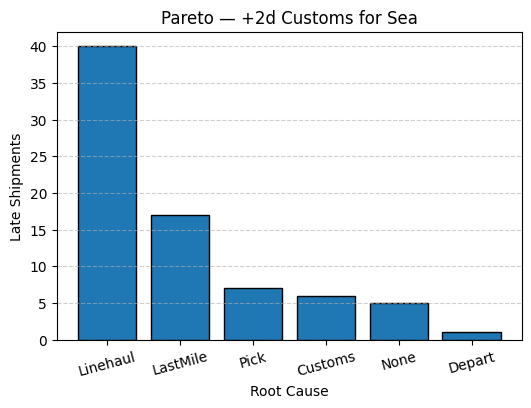

In [4]:
stages1 = stages0.copy()
stages1.loc[stages1["Mode"]=="Sea", "Customs"] += 2.0

stages1, pareto1, otif1 = recompute_metrics(stages1)
print(f"OTIF after +2d customs for Sea: {otif1:.1f}%")
plot_pareto(pareto1, "Pareto — +2d Customs for Sea")

## Scenario 2 — Linehaul Disruption (Road +1 day)

OTIF after +1d Road linehaul: 79.0%


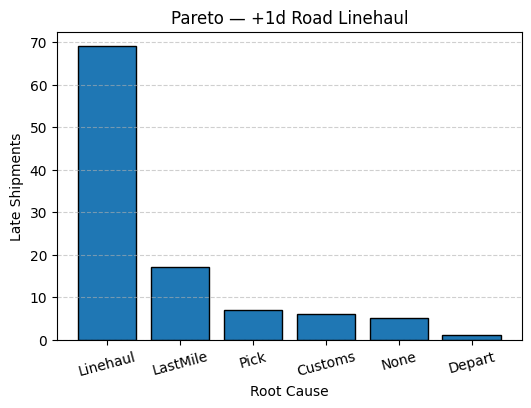

In [5]:
stages2 = stages0.copy()
stages2.loc[stages2["Mode"]=="Road", "Linehaul"] += 1.0

stages2, pareto2, otif2 = recompute_metrics(stages2)
print(f"OTIF after +1d Road linehaul: {otif2:.1f}%")
plot_pareto(pareto2, "Pareto — +1d Road Linehaul")

## Scenario 3 — SLA Relaxation (Sea 18 → 20 days)

OTIF after relaxing Sea SLA to 20: 89.4%


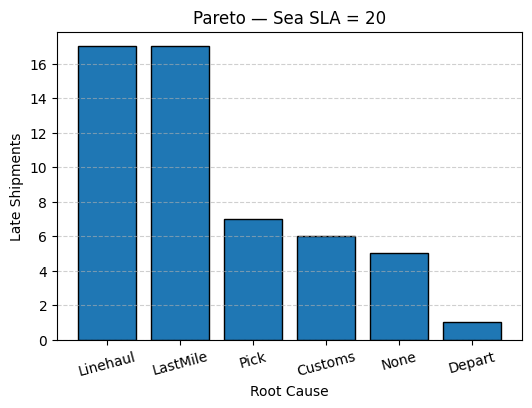

In [6]:
stages3 = stages0.copy()
stages3.loc[stages3["Mode"]=="Sea", "SLA"] = 20

stages3, pareto3, otif3 = recompute_metrics(stages3)
print(f"OTIF after relaxing Sea SLA to 20: {otif3:.1f}%")
plot_pareto(pareto3, "Pareto — Sea SLA = 20")

## Scenario 4 — Process Improvement (Pick & Depart −20%)

OTIF after -20% Pick & Depart: 89.4%


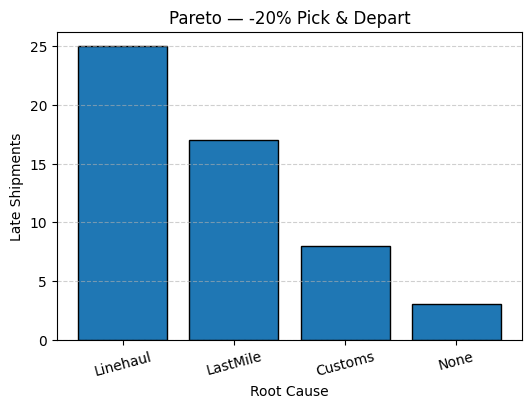

In [7]:
stages4 = stages0.copy()
stages4["Pick"]   = stages4["Pick"] * 0.8
stages4["Depart"] = stages4["Depart"] * 0.8

stages4, pareto4, otif4 = recompute_metrics(stages4)
print(f"OTIF after -20% Pick & Depart: {otif4:.1f}%")
plot_pareto(pareto4, "Pareto — -20% Pick & Depart")

## Scenario 5 — Late Definition Change (Late if LeadTime > SLA + 1)

OTIF with Late defined as LeadTime > (SLA+1): 96.6%


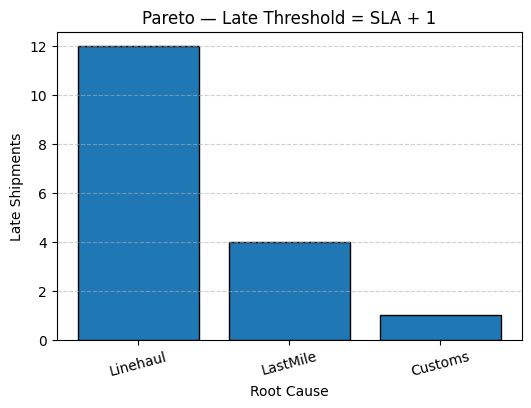

In [8]:
stages5, pareto5, otif5 = recompute_metrics(stages0, late_offset_days=1)
print(f"OTIF with Late defined as LeadTime > (SLA+1): {otif5:.1f}%")
plot_pareto(pareto5, "Pareto — Late Threshold = SLA + 1")

## Summary — OTIF Comparison Across Scenarios

In [9]:
summary = pd.DataFrame({
    "Scenario": [
        "Baseline", "+2d Sea Customs", "+1d Road Linehaul",
        "Sea SLA=20", "-20% Pick&Depart", "Late>SLA+1"
    ],
    "OTIF_%": [
        (1 - stages0["Late"].mean())*100, otif1, otif2, otif3, otif4, otif5
    ]
}).round(1)

summary

,Scenario,OTIF_%
0,Baseline,87.6
1,+2d Sea Customs,84.8
2,+1d Road Linehaul,79.0
3,Sea SLA=20,89.4
4,-20% Pick&Depart,89.4
5,Late>SLA+1,96.6
